## 处理roe数据
筛选出极值点，分段
是否有效

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [295]:
import scipy.signal as signal
from datetime import datetime
from scipy.stats.mstats import winsorize

In [548]:
from random import randint
from random import choices, sample

In [117]:
roePath = "/Users/zch/Desktop/internship/Jan14/filteredROE.xlsx"
diffPath = "/Users/zch/Desktop/internship/Jan14/diffROE59.xlsx"
roe = pd.read_excel(roePath)
diff = pd.read_excel(diffPath)

In [414]:
def getCompanyByCode(code, data):
    '''
    code, data; company, df; y, series
    '''
    company = data[data["code"].str.contains(code)]
    y = company.iloc[0, 2:]
    # 进行缩尾处理
    # TODO
    return company, y

def getYRolling(y, n=8, gaussian=True, center=True):
    '''
    获取滚动值，y series roe数据
    '''
    if gaussian:
        yRolling = y.rolling(n, win_type="gaussian", center=center).mean(std=np.std(y,ddof=1))
    else:
        yRolling = y.rolling(n, center=center).mean()
    return yRolling

def getExtreme(yRolling, order=3):
    '''
    返回极值下标
    '''
    y = np.array(yRolling)
    maximum = signal.argrelextrema(y, np.greater_equal, order=order)[0]
    minimum = signal.argrelextrema(y, np.less_equal, order=order)[0]
    return maximum, minimum

def drawROEandExtreme(maxs, mins, y, yRolling, company, minBool=True, maxBool=True, roeBool=True):
    '''
    绘制roe和极点, company, df 只有一行
    '''
    fig, axs = plt.subplots(figsize=(12, 5))
    x = [datetime.strptime(d, '%Y-%m').date() for d in company.columns[2:]]
    # y = company.iloc[0, 2:]
    if roeBool:
        axs.plot(x, y, label="roe")
    axs.plot(x, yRolling, label="roll")
    xMax = [datetime.strptime(d, '%Y-%m').date() for d in maxs.index]
    xMin = [datetime.strptime(d, '%Y-%m').date() for d in mins.index]
    axs.scatter(xMax, maxs, label="max", c='r')
    axs.scatter(xMin, mins, label="min", c='g')
    if maxBool:
        for i, tempX in enumerate(xMax):
            axs.annotate(str(tempX)[:-3], xy=(tempX, maxs[i]+0.1), c="r")
    if minBool:
        for i, tempX in enumerate(xMin):
            axs.annotate(str(tempX)[:-3], xy=(tempX, mins[i]-0.1), c="g")
    axs.set_title(company.iloc[0, 0])  # code
    fig.legend()

def pickOne(data):
    one = randint(0, len(data)-1)
    companyCode = data.iloc[one, 0]
    companyName = data.iloc[one, 1]
    return companyCode, companyName

def showOne(code, data, n=8, gaussian=True, center=True, order=3, maxBool=True, minBool=True, roeBool=True):
    company, y = getCompanyByCode(code, data)
    yRolling = getYRolling(y, n=n, gaussian=gaussian, center=center)
    maximum, minimum = getExtreme(yRolling, order)
    maxs, mins = yRolling[maximum], yRolling[minimum]
    drawROEandExtreme(maxs, mins, y, yRolling, company, maxBool, minBool, roeBool)

## 1 极大值极小值处理

In [330]:
company, y = getCompanyByCode("600031", diff)

In [331]:
yRolling = getYRolling(y, center=True)

In [332]:
maximum, minimum = getExtreme(yRolling)
maxs = yRolling[maximum]
mins = yRolling[minimum]

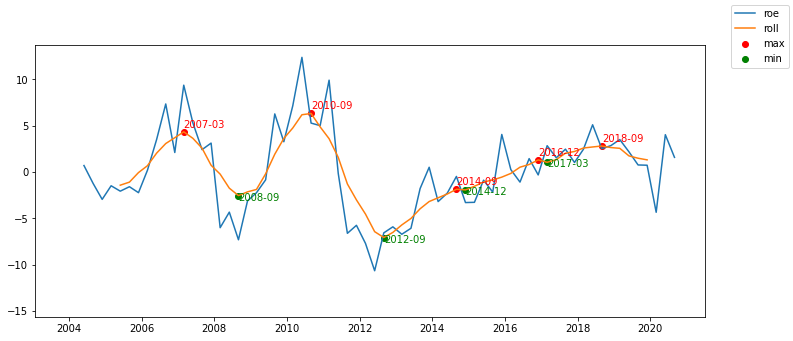

In [333]:
drawROEandExtreme(maxs, mins, y, yRolling, company)  # 三一重工

### 1.1 极值

600302.SH 标准股份


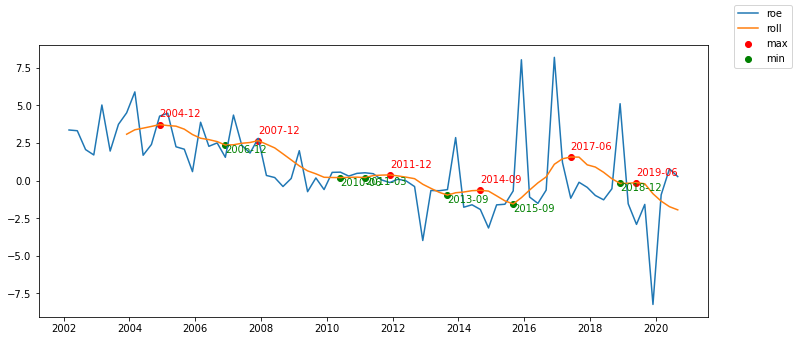

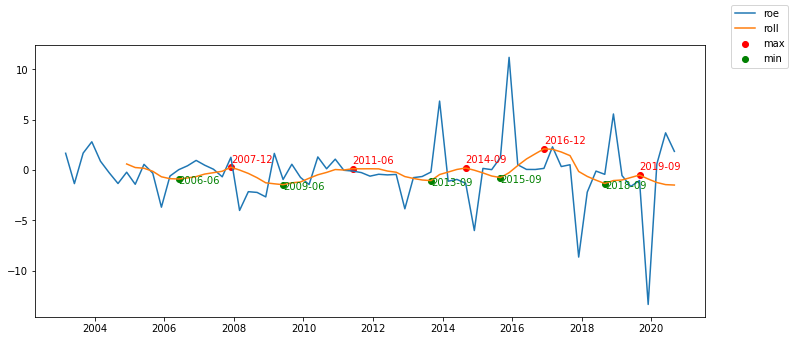

In [257]:
code, name = pickOne(roe)
# code = "600528.SH"
# name = "中铁工业"

# 差分前后变化大
# code = "600761.SH"
# name = "安徽合力"

# 没有趋势
# code = "000570.SZ"
# name = "苏常柴A"
print(code, name)
showOne(code, roe, order=2)
showOne(code, diff, order=2)

## 使用np.convolve尝试，效果差不多
去除噪点还是需要平滑窗口期拉长

In [ ]:
# wi=np.ones(int(8))/float(8)
# tempy = np.convolve(y, wi,'same')
# fig, axs = plt.subplots(figsize=(12, 5))
# x = [datetime.strptime(d, '%Y-%m').date() for d in y.index]
# axs.plot(x, y)
# axs.plot(x, tempy)

## 噪点和筛选
- 噪点
    - [x] 改为直接调成求极值的order=2，即与相邻两个之间比较
    - 增大窗口期
    - 设置规则，清洗极点数据
- 公司选择
    - 设置阈值，比如极大值和极小值相差超过x认为是比较有效的？
    
先选择那些趋势明显的公司，再想办法去除噪点

600302.SH 标准股份


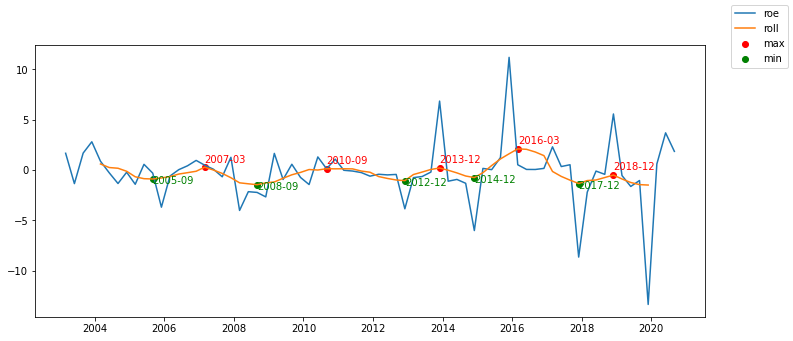

In [356]:
code, name = pickOne(roe)
# code = "600031.SH"
# name = "三一重工"

# 差分前后变化大
# code = "600761.SH"
# name = "安徽合力"

# 没有趋势
# code = "000570.SZ"
# name = "苏常柴A"

# 末尾噪点多
# code = "600320.SH" 
# name = "振华重工"

print(code, name)
# showOne(code, roe, order=1, center=True)
# showOne(code, diff, order=1, center=True)
showOne(code, diff, order=3, center=True)

### 如何选择公司
- 根据极点个数 不同公司可能不同
    - 用均值或者分位数当阈值
- 根据最大值和最小值的差值（但公司ROE本身不同，同行业可能可以设置一个阈值
- 看极大值和极小值的差值有没有达到n个标准差（其中标准差用平滑化后的进行衡量

In [522]:
# 查看极值是否超过阈值
def isGoodCompany(maxs, mins, std, n=1, threshold=0.6):
    '''
    根据相邻极值的最大最小差别是否超过n个标准差来确定
    '''
    minMax = pd.concat([maxs, mins]).sort_index()
    minMaxDiff = np.abs(minMax.diff(1))  # 差值
    return (minMaxDiff>std*n).sum()>threshold*(len(minMaxDiff)-1)

In [582]:
# 选择函数合并
def selectCompany(diff, n=1, threshold=0.6, order=3, missn=20, minExtreme=3):
    '''
    diff 差分数据; n几个标准差, missn允许几个季度缺失
    minExtreme 极值点比minExtreme多
    '''
    temp = diff.copy()
    # 去除全为NaN的年份
    temp = temp.dropna(axis=1, how="all")
    tempCodes = temp["code"].values
    goodCodes = []
    for tempCode in tempCodes:
        tempCompany, y = getCompanyByCode(tempCode, temp)
        tempYRolling = getYRolling(y)
        # 至少10年数据
        if tempYRolling.count()<missn:
            continue
        tempStd = np.std(tempYRolling, ddof=1)
        maximum, minimum = getExtreme(tempYRolling, order=order)
        # 极值点比minExtreme多
        if len(maximum)+len(minimum)<minExtreme:
            continue
        maxs, mins = tempYRolling[maximum], tempYRolling[minimum]
        if isGoodCompany(maxs, mins, tempStd, n=n, threshold=threshold):
            goodCodes.append(tempCode)
    return goodCodes

## 尝试从整个机械行业中筛选
可以适当提高筛选标准
- 标准差倍数 n
- 极值超过门槛值比例 threshold

In [461]:
machinePath = "/Users/zch/Desktop/internship/Jan14/机械roeData.xlsx"
machineROE = pd.read_excel(machinePath)

In [465]:
machineDiff = pd.concat([machineROE.iloc[:,:2],machineROE.iloc[:,2:].diff(4, axis=1)], axis=1)

In [467]:
machineDiff.to_excel("machineROEDiff.xlsx",index=False)

### 选择


In [554]:
goodCodes = selectCompany(machineDiff, n=2, threshold=0.6, order=3, missn=20)
print(len(goodCodes))

45


In [555]:
temp = machineDiff[machineDiff["code"].apply(lambda x: x in goodCodes)]
print(len(temp))

45


In [493]:
# temp.to_excel("machineGoodCompanies1.xlsx", index=False)

197    精测电子
Name: name, dtype: object 300567.SZ
241    三一重工
Name: name, dtype: object 600031.SH
39    奥普光电
Name: name, dtype: object 002338.SZ


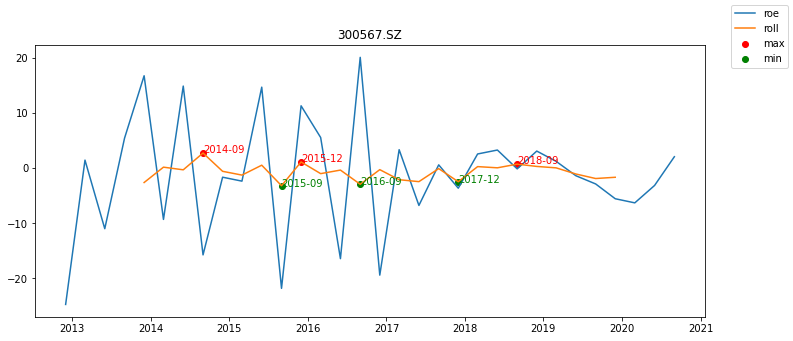

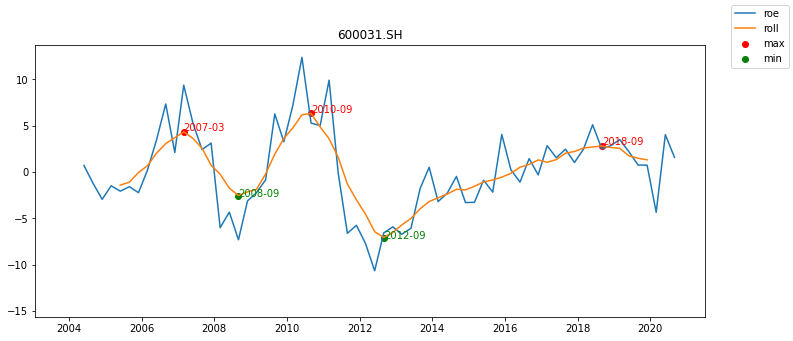

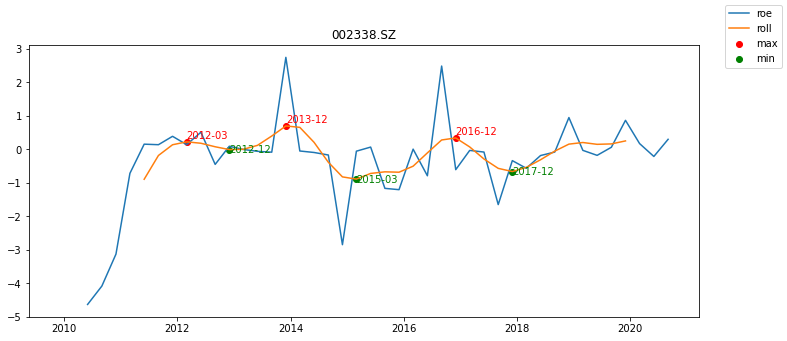

In [620]:
# 随机挑选3个 看趋势
for code in sample(goodCodes, k=3):
    print(temp[temp["code"]==code].name, code)
    showOne(code, temp, roeBool=True, order=3)

### 按不同筛选条件导出
命名格式 good-n-threshold-missn.xlsx
order默认为3

In [599]:
def exportGoodCompanies(diff, n=1, threshold=0.6, missn=20, minExtreme=3, exportBool=True):
    goodCodes = selectCompany(diff, n=n, threshold=threshold, missn=missn, minExtreme=minExtreme)
    print("共找到%d个公司"%len(goodCodes))
    temp = diff[diff["code"].apply(lambda x: x in goodCodes)]
    if exportBool:
        path = f"diff-n{n}-th{int(threshold*10)}-m{missn}-ex{minExtreme}.xlsx"
        temp.to_excel(path, index=False)
    return temp, goodCodes

In [600]:
temp, goodCodes = exportGoodCompanies(machineDiff, n=2, threshold=0.5, missn=20, exportBool=True, minExtreme=3)

共找到38个公司


In [601]:
temp.head()

,code,name,2000-03,2000-06,2000-09,2000-12,2001-03,2001-06,2001-09,2001-12,...,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09,2020-12
4,000528.SZ,柳工,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8576,0.3048,-0.0064,0.3567,0.9474,0.5408,-1.5118,1.1505,0.6874,NaN
5,000530.SZ,冰山冷热,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.9766,-0.5305,2.3739,-0.9433,-0.5474,-1.5475,-4.8750,1.0084,0.9535,NaN
8,000584.SZ,哈工智能,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.6145,-0.5203,-0.9230,-1.0394,-1.2613,-1.7084,-1.3093,-2.1302,-1.1252,NaN
9,000680.SZ,山推股份,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0723,-0.1437,-0.0085,-0.9308,1.0539,-0.8482,-0.5467,1.1283,-1.0969,NaN
23,002031.SZ,巨轮智能,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.1158,-0.4884,-0.0538,-0.7275,2.1567,-2.4960,-0.0162,-0.0999,-2.4469,NaN


['梅安森'] 300275.SZ
['雪人股份'] 002639.SZ
['安徽合力'] 600761.SH


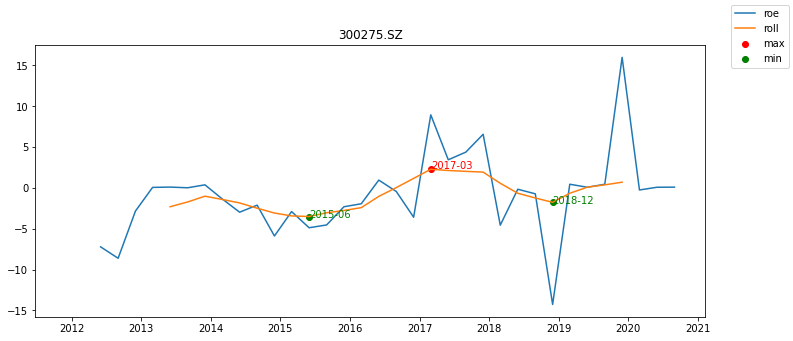

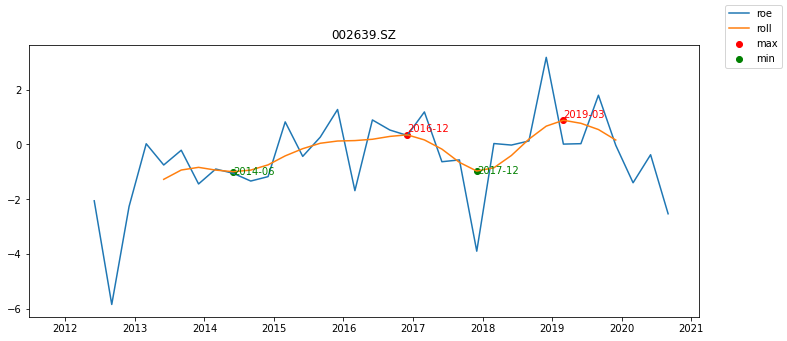

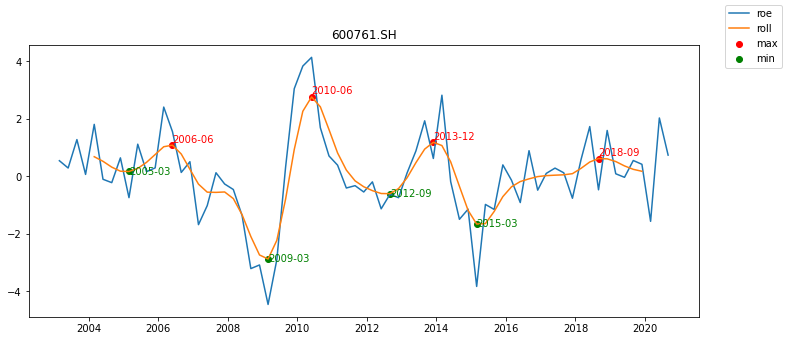

In [603]:
for code in sample(goodCodes, k=3):
    print(temp[temp["code"]==code]["name"].values, code)
    showOne(code, temp, roeBool=True, order=3)